In [1]:
import torch
import logging
import sys

from model.vision_transformer_utils import (
    WarmupCosineSchedule,
    CosineWDSchedule)
from model.vision_transformer_utils import trunc_normal_, init_opt, apply_masks_targets
from model.ijepa_utils import AverageMeter
from model.vision_transformer import VisionTransformer, VisionTransformerPredictor

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logger = logging.getLogger()



def load_checkpoint(
    device,
    r_path,
    encoder,
    predictor,
    target_encoder,
    opt,
    scaler,
):
    try:
        checkpoint = torch.load(r_path, map_location=torch.device('cpu'))
        epoch = checkpoint['epoch']

        # -- loading encoder
        pretrained_dict = checkpoint['encoder']
        msg = encoder.load_state_dict(pretrained_dict)
        logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading predictor
        pretrained_dict = checkpoint['predictor']
        msg = predictor.load_state_dict(pretrained_dict)
        logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading target_encoder
        if target_encoder is not None:
            print(list(checkpoint.keys()))
            pretrained_dict = checkpoint['target_encoder']
            msg = target_encoder.load_state_dict(pretrained_dict)
            logger.info(f'loaded pretrained encoder from epoch {epoch} with msg: {msg}')

        # -- loading optimizer
        if opt is not None:
            opt.load_state_dict(checkpoint['opt'])
        if scaler is not None:
            scaler.load_state_dict(checkpoint['scaler'])
        logger.info(f'loaded optimizers from epoch {epoch}')
        logger.info(f'read-path: {r_path}')
        del checkpoint

    except Exception as e:
        logger.info(f'Encountered exception when loading checkpoint {e}')
        epoch = 0

    return encoder, predictor, target_encoder, opt, scaler, epoch


In [2]:
def generateMasks(data):
    # :param data: tensor of shape [B, R, C, D]
    # :returns: (data, 1x masks_enc, 4x masks_pred)
    import numpy as np
    grid_pd = np.load(r"E:\estudy\ST-SSL\code\ST-SSL\data\NYCTaxi\grid_pd.npy")
    _pd = grid_pd.flatten()
    B, R, C, D = data.size()

    # Initialize masks
    masks_enc = torch.zeros(B, R, C, dtype=torch.uint8)
    masks_pred = torch.zeros(4, B, R, C, dtype=torch.uint8)

    ## select size of context and target masks before sample loop.
    ## grid_size: 20x10
    
    masks_enc = masks_enc.flatten(1)
    masks_pred = masks_pred.flatten(2)
    ctxt_size = torch.randint(50, 100, (1,)).item()       ## low (inclusive), high (exclusive)
    trgt_size = torch.randint(50//4, 100//4, (1,)).item()  
    # print(f"ctxt_size: {ctxt_size}, trgt_size: {trgt_size}")
    # print(f"masks_enc.shape: {masks_enc.shape}, masks_pred.shape: {masks_pred.shape}")  ##m asks_enc.shape: torch.Size([32, 200]), masks_pred.shape: torch.Size([4, 32, 200])
    for b in range(B):
        pd = _pd.copy()
        # print(f"\n\ncxtz: {ctxt_size}")
        ctxt_indices = np.random.choice(R*C, size=ctxt_size, replace=False, p=pd)
        # print(f"mask_enc.shape: {masks_enc.shape} ")
        # print(f"mask_enc.shape: {masks_enc.shape} ")
        masks_enc[b, ctxt_indices] = 1 
        pd[ctxt_indices] = 0           ## set ctxt indices to 0 so that those nodes are not repeated in trgt masks
        pd /= pd.sum()
        # Generate four prediction masks (can be overlapping with each other, but not with context mask)
        for i in range(4):
            # Smaller random sizes for prediction masks
            trgt_indices = np.random.choice(R*C, size = trgt_size, replace=False, p=pd) 
            masks_pred[i, b, trgt_indices] = 1
    masks_enc = masks_enc.view(B, 1, R*C)
    masks_pred = masks_pred.view(4, B, R*C)
    return (data, masks_enc, masks_pred.transpose(0, 1))  




!!Scaling is off!!


data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2) 

!!train shuffle is false!!


INFO:root:Using AdamW
INFO:root:loaded pretrained encoder from epoch 15 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 15 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 15 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 15
INFO:root:read-path: E:\estudy\ST-SSL\code\ST-SSL\logs\singleBLK_dim8_newSampling\jepa-ep16.pth.tar


C:\Users\omera\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torch\cuda\amp\grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


torch.Size([32, 200, 8])


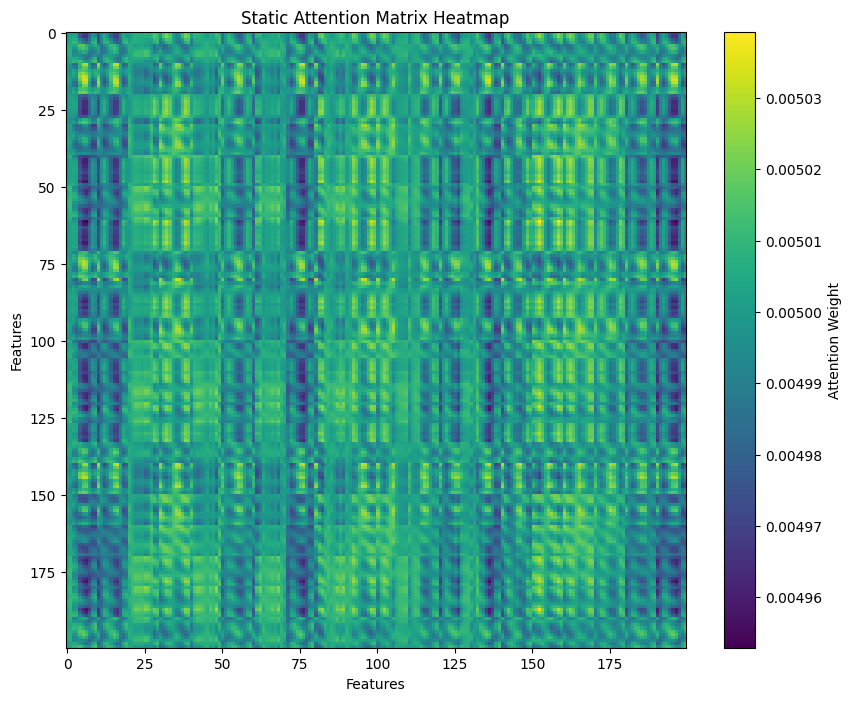

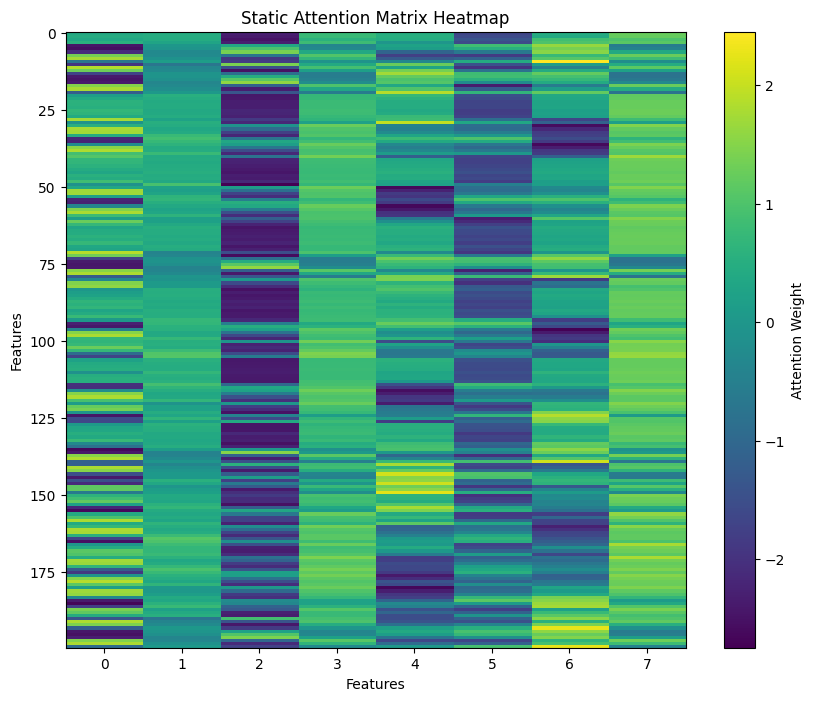

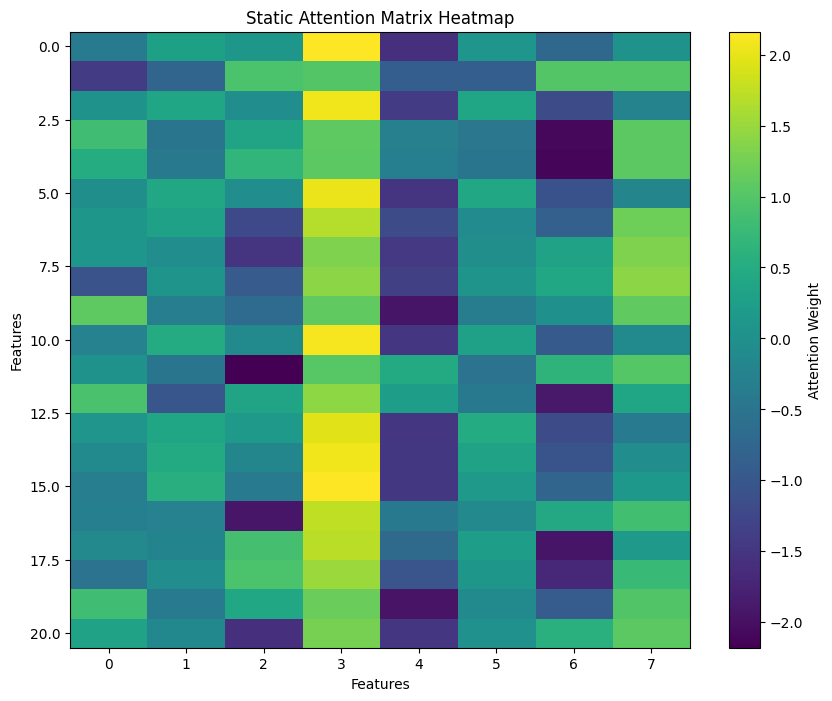

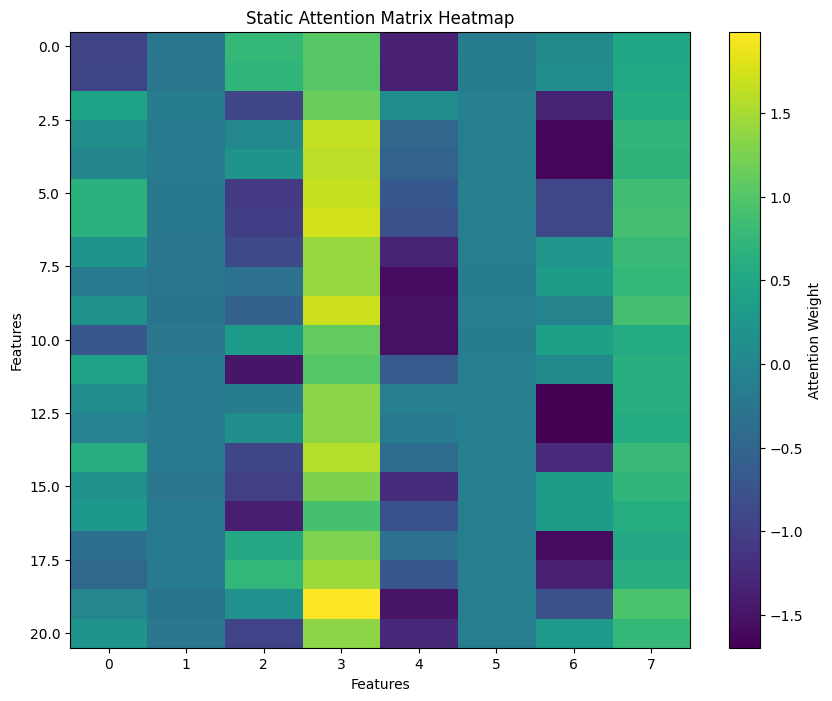

In [39]:
def plot_adj(path, l):
    load_model=True
    import time
    import yaml
    import sys
    import torch
    
    sys.path.append('.')
    sys.path.append('..')
    from lib.dataloader import get_dataloader
    args = {"data_dir": r"data", "dataset": "NYCTaxi", "batch_size": 32, "test_batch_size": 32, "rows": 20, "cols": 10, "num_epochs": 100}
    dataloader = get_dataloader(
        data_dir=args['data_dir'], 
        dataset=args['dataset'], 
        batch_size=args['batch_size'], 
        test_batch_size=args['test_batch_size'],
        scalar_type='Standard'
    )
    train_loader = dataloader['train']
    test_loader = dataloader['test']
    val_loader = dataloader['val']

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder = VisionTransformer(
            img_size=(args["rows"], args["cols"]),
            patch_size=1,
            in_chans=2,
            embed_dim=8,
            predictor_embed_dim=None,
            depth=1,
            predictor_depth=None,
            num_heads=1,
            mlp_ratio=2,
            qkv_bias=True,
            qk_scale=None,
            drop_rate=0.2,
            attn_drop_rate=0.2,
            drop_path_rate=0.1,
            norm_layer=torch.nn.LayerNorm,
            init_std=0.02
        )
    predictor = VisionTransformerPredictor(
        img_size=(args["rows"], args["cols"]),
        embed_dim=8,
        predictor_embed_dim=8//2,
        depth=1,
        num_heads=1,
        mlp_ratio=2,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.2,
        attn_drop_rate=0.2,
        drop_path_rate=0.1,
        norm_layer=torch.nn.LayerNorm,
        init_std=0.02
    )

    import copy
    target_encoder = copy.deepcopy(encoder)
    encoder.eval().to(device)
    predictor.eval().to(device)
    target_encoder.eval().to(device)




    wd = 0.04
    final_wd = 0.4
    start_lr = 0.0002
    final_lr = 1.0e-06
    lr = 0.001
    ipe = len(train_loader)
    warmup = 40
    ipe_scale = 1.0
    use_bfloat16 = True
    optimizer, scaler, scheduler, wd_scheduler = init_opt(
            encoder=encoder,
            predictor=predictor,
            wd=wd,
            final_wd=final_wd,
            start_lr=start_lr,
            ref_lr=lr,
            final_lr=final_lr,
            iterations_per_epoch=ipe,
            warmup=warmup,
            num_epochs=args["num_epochs"],
            ipe_scale=ipe_scale,
            use_bfloat16=use_bfloat16)

    ema = [0.996, 1.0]
    ipe = len(train_loader)
    ipe_scale = 1.0
    momentum_scheduler = (ema[0] + i*(ema[1]-ema[0])/(ipe*args["num_epochs"]*ipe_scale)
                            for i in range(int(ipe*args["num_epochs"]*ipe_scale)+1))
    
    if load_model:
        encoder, predictor, target_encoder, optimizer, scaler, start_epoch = load_checkpoint(
            device=device,
            r_path=path,
            encoder=encoder,
            predictor=predictor,
            target_encoder=target_encoder,
            opt=optimizer,
            scaler=scaler)
        for _ in range(start_epoch*ipe):
            scheduler.step()
            wd_scheduler.step()

            next(momentum_scheduler)
    ## just get the attention maps from the context_encoder (input whole image)

    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader):
            data = data[:, 0, :, :].squeeze(1)
            B, N, D = data.size()
            data = data.view(B, args["rows"], args["cols"], D).to(device)
            imgs, masks_enc, masks_pred = generateMasks(data)
            imgs = imgs.permute(0, 3, 1, 2)  # [B, D, R, C]
            masks_pred = masks_pred.flatten(2)  # [B, 4, R*C]
            masks_enc = masks_enc.flatten(1).unsqueeze(1)  # [B, 1, R*C]
            
            """ see whole image as context """
            # masks_enc=torch.ones_like(masks_enc)
            # masks_enc=torch.zeros_like(masks_enc)
            # masks_enc[:, :, 0:2] = 1
            def forward_context():    ## mask context tokens before encoding
                z, attn_list = encoder(imgs, masks=masks_enc)  ## VisionTransformer
                return z, attn_list
            def forward_target():
                z, attn_list = target_encoder(imgs, masks=None)  ## VisionTransformer
                # z = apply_masks_targets(z, masks_pred)
                return z, attn_list
            zt, attn_list_1 = forward_target()  # Target encoder forward pass
            zc, _ = forward_context()  # Context encoder forward pass
            zp = predictor(zc, masks_enc, masks_pred)   ## VisionTransformerPredictor
            


    import matplotlib.pyplot as plt

    # Generate the same 200x200 attention matrix
    # np.random.seed(42)
    attn1 = attn_list_1[l][0].squeeze(0).softmax(-1).cpu().numpy()[:,:]
    print(zc.shape)
    zc = zc[0].squeeze(0).cpu().numpy()
    
    # Create a static heatmap using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(attn1, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Static Attention Matrix Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()


    # Create a static heatmap using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(zc, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Static Attention Matrix Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

    zt = zt[0].squeeze(0).cpu().numpy()
    # Create a static heatmap using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(zt, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Static Attention Matrix Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

    zp = zp[0].squeeze(0).cpu().numpy()
    # Create a static heatmap using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(zp, cmap='viridis', aspect='auto')
    plt.colorbar(label='Attention Weight')
    plt.title('Static Attention Matrix Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Features')
    plt.show()

    return attn1

e=16
load_path = fr"E:\estudy\ST-SSL\code\ST-SSL\logs\singleBLK_dim8_newSampling\jepa-ep{e}.pth.tar"
att = plot_adj(load_path, 0)



!!Scaling is off!!


data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2) 

!!train shuffle is false!!


INFO:root:Using AdamW
INFO:root:loaded pretrained encoder from epoch 15 with msg: <All keys matched successfully>
INFO:root:loaded pretrained encoder from epoch 15 with msg: <All keys matched successfully>
['encoder', 'predictor', 'target_encoder', 'opt', 'scaler', 'epoch', 'loss', 'batch_size', 'world_size', 'lr']
INFO:root:loaded pretrained encoder from epoch 15 with msg: <All keys matched successfully>
INFO:root:loaded optimizers from epoch 15
INFO:root:read-path: E:\estudy\ST-SSL\code\ST-SSL\logs\singleBLK_dim8_newSampling\jepa-ep16.pth.tar
torch.Size([32, 200, 8])


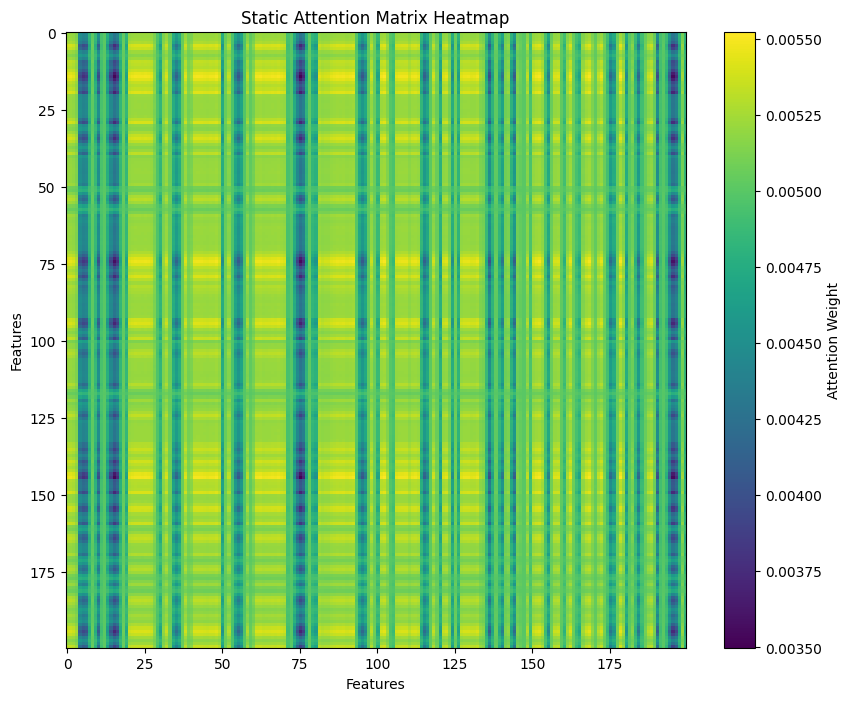

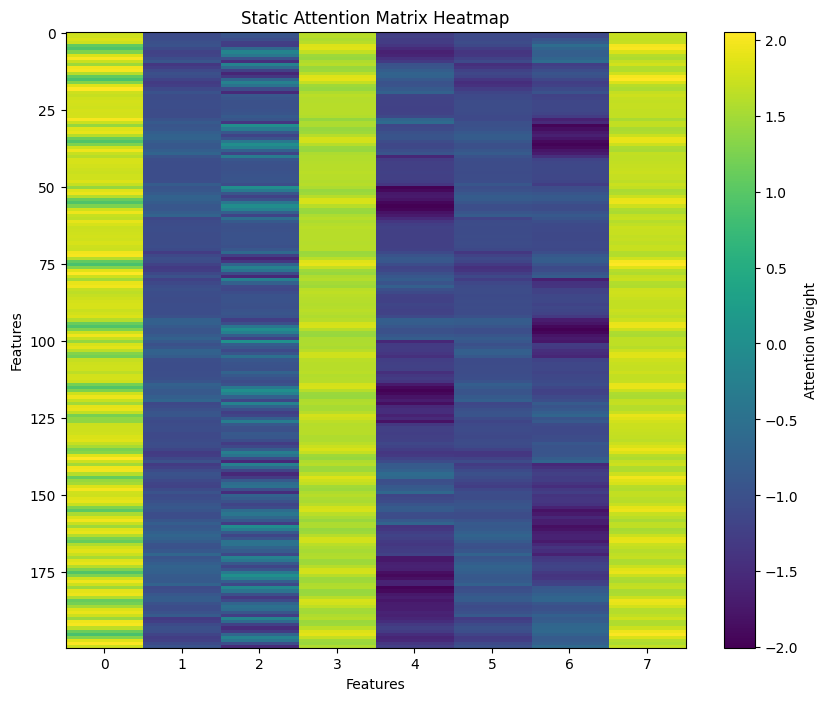

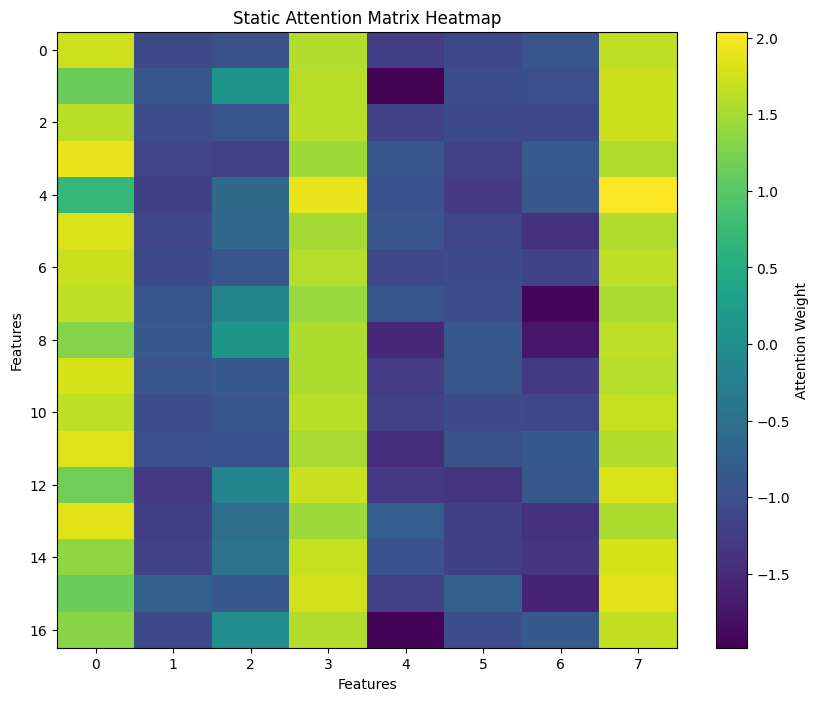

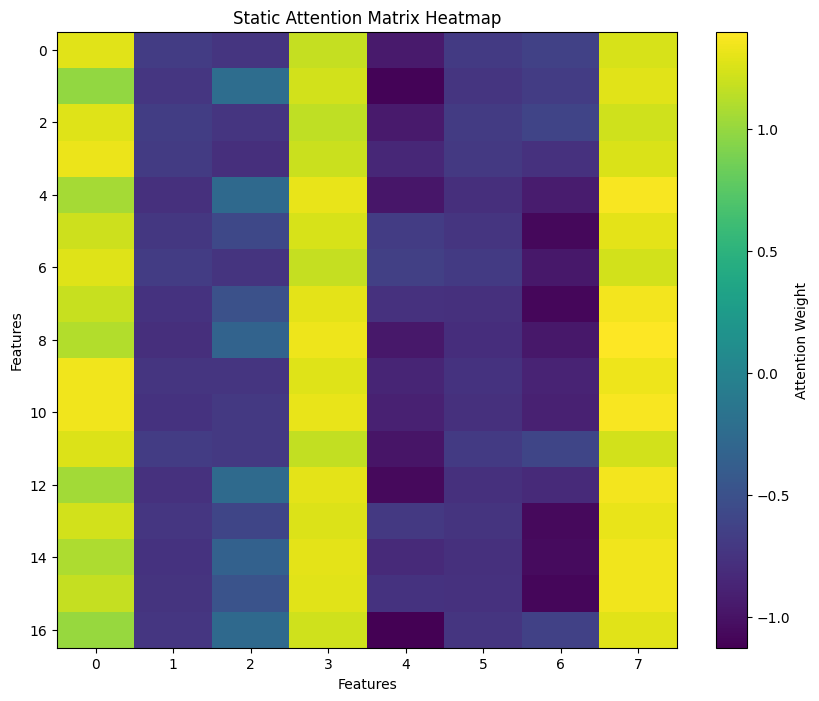

In [26]:

# for i in range(10, 501, 10):
e=16
load_path = fr"E:\estudy\ST-SSL\code\ST-SSL\logs\singleBLK_dim8_newSampling\jepa-ep{e}.pth.tar"
att = plot_adj(load_path, 0)

In [37]:
np.savez(r'E:\estudy\ST-SSL\code\ST-SSL\data\NYCTaxi\randomSampling_symmetric_adj_mx.npz', adj_mx=att_modifiedSym)

(200, 200)
[[0.00520167 0.00521088 0.00519262 ... 0.00482597 0.00509949 0.00484418]
 [0.0052004  0.00520954 0.00519142 ... 0.00482716 0.00509889 0.00484521]
 [0.00521345 0.00522324 0.00520434 ... 0.00481833 0.00510751 0.00483751]
 ...
 [0.00516602 0.00517416 0.00515857 ... 0.00485511 0.00508444 0.00487457]
 [0.00521745 0.00522763 0.00520918 ... 0.00481931 0.005115   0.0048408 ]
 [0.0053214  0.00533616 0.00531134 ... 0.00474778 0.00517809 0.00477185]]
<class 'numpy.ndarray'>


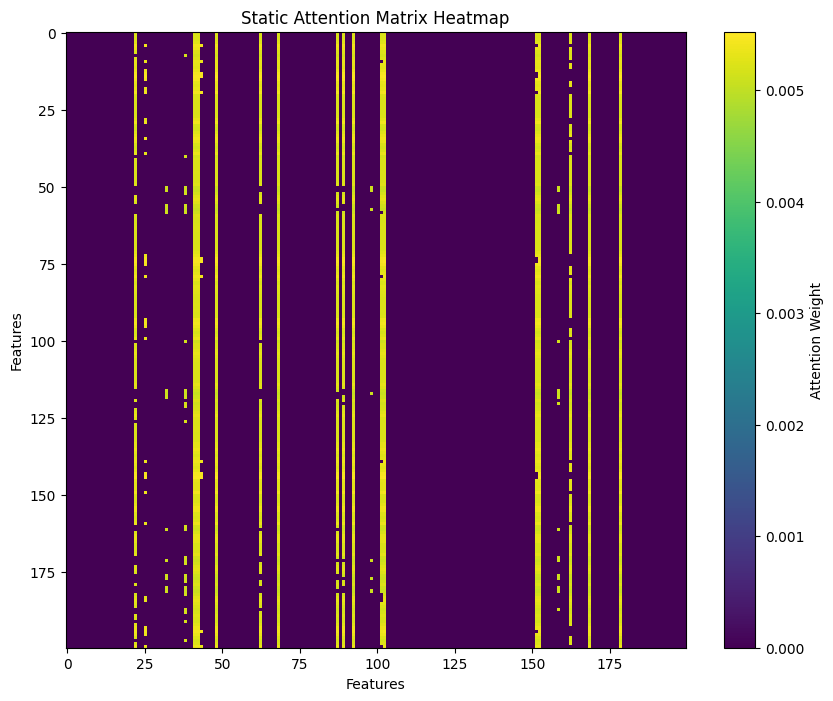

In [35]:
import matplotlib.pyplot as plt
print(att.shape)
print(att)
print(type(att))
plt.figure(figsize=(10, 8))
att_modifiedSym = (att_modified + att_modified.T) / 2
plt.imshow(att_modified, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.title('Static Attention Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

plt.show()

In [29]:
import numpy as np

# Assuming att is your 200x200 numpy array
# For demonstration, let's create a sample 200x200 numpy array
np.random.seed(0)  # Seed for reproducibility

# Vectorized approach to keep only the top 8 values in each row
def keep_top_8_vectorized(arr):
    # Shape of the array
    rows, cols = arr.shape

    # Get indices of each element when the array is sorted along each row
    sorted_indices = np.argsort(arr, axis=1)

    # We want to zero out all but the top 8 values, so we select all but the last 8 columns of indices
    threshold_indices = sorted_indices[:, :-16]

    # Copy the array to avoid changing the original data
    result = arr.copy()

    # Flatten the row indices to match the flattened threshold indices
    row_indices = np.arange(rows).reshape(-1, 1)

    # Use advanced indexing to set the unwanted elements to zero
    result[row_indices, threshold_indices] = 0

    return result

# Apply the function
att_modified = keep_top_8_vectorized(att)
